In [1]:
import pandas as pd

# import the data including all reviews from Indianapolis and sample 10% of it
reviews = pd.read_csv('csv_data/indianapolis_reviews.csv')
reviews = reviews.sample(frac=0.1, random_state=0)

In [2]:
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import unidecode

# strip accents and use lowercase for all the text
reviews['text'] = [unidecode.unidecode(review_text).lower() for review_text in reviews['text']]

# tokenize the reviews using spaCy
spacy_tokenizer = English()
reviews['spacy_token'] = [[token.text for token in spacy_tokenizer(review_text)] for review_text in reviews['text']]

# remove stop words
reviews['spacy_token'] = [list(filter(lambda word: word not in STOP_WORDS, list_of_tokens)) for list_of_tokens in reviews['spacy_token']]

# check the results from pre-processing
reviews[['text', 'spacy_token']].head()

# create a list with inputs in the ideal format for BoW and TF-IDF
pre_processed_inputs = [' '.join(review) for review in reviews['spacy_token'].tolist()]

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

# create the BoW representation for the set
count_vec = CountVectorizer(max_features=1024, ngram_range=(1,2))
bow_representation = count_vec.fit_transform(pre_processed_inputs)

# create the array with BoW and normalize it
bow_array = bow_representation.toarray()
bow_normalized = [vector/sum(vector) if sum(vector) != 0 else vector for vector in bow_array]

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create the TF-IDF representation for the set
tfidf_vec = TfidfVectorizer(max_features=1024, ngram_range=(1,2))
tfidf_representation = tfidf_vec.fit_transform(pre_processed_inputs)

# create the array with TF-IDF and normalize it
tfidf_array = tfidf_representation.toarray()
tfidf_normalized = [vector/sum(vector) if sum(vector) != 0 else vector for vector in tfidf_array]

In [5]:
import numpy as np

# get our outputs in an array format
bow_normalized = np.array(bow_normalized)
tfidf_normalized = np.array(tfidf_normalized)

# check if the normalized arrays were done properly
print(bow_normalized[0].sum())
print(tfidf_normalized[0].sum())

1.0
1.0


In [6]:
import keras.models as models

# reconstruct the autoencoder from a saved file
autoencoder = models.load_model("autoencoder_v1")

# use the (full) autoencoder to predict the bow just to test it
bow_autoencoder = autoencoder.predict(bow_normalized)

In [7]:
# create a model that only encodes the vectors
encoder = models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_2').output)

# create a compressed representation for the vectors and check new shape
bow_encoded = encoder.predict(bow_normalized)
print(bow_encoded.shape)

# create a compressed representation for the vectors and check new shape
tfidf_encoded = encoder.predict(tfidf_normalized)
print(tfidf_encoded.shape)

(36149, 16)
(36149, 16)


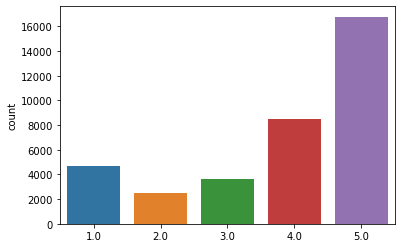

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# let's visualize the distribution of stars to check how skewed is the data
stars = np.array(reviews['stars'].tolist())
sns.countplot(x=stars)
plt.savefig('figures/indianapolis_stars_distribution.png', dpi=80)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

# using kNN with encoded BoW
X_train, X_test, y_train, y_test = train_test_split(bow_encoded, stars, test_size = 0.25, random_state=0)
knn = KNeighborsRegressor(n_neighbors=20).fit(X_train, y_train)
print("kNN score:", knn.score(X_test, y_test))

kNN score: 0.19078472185084538


In [10]:
from sklearn.tree import DecisionTreeRegressor

# using decision trees with encoded BoW
tree = DecisionTreeRegressor(max_depth=4).fit(X_train, y_train)
print("Decision tree score:", tree.score(X_test, y_test))

Decision tree score: 0.09147054442048341


In [11]:
from sklearn.svm import SVR

# using SVMs with encoded BoW
svm = SVR().fit(X_train, y_train)
print("SVM score:", svm.score(X_test, y_test))

SVM score: 0.07961893175320423


In [12]:
# repeat the three methods for the encoded TF-IDF
X_train, X_test, y_train, y_test = train_test_split(tfidf_encoded, stars, test_size = 0.25, random_state=0)

# using kNN with encoded TF-IDF
knn = KNeighborsRegressor(n_neighbors=20).fit(X_train, y_train)
print("kNN score:", knn.score(X_test, y_test))

# using decision trees with encoded TF-IDF
tree = DecisionTreeRegressor(max_depth=4).fit(X_train, y_train)
print("Decision tree score:", tree.score(X_test, y_test))

# using SVMs with encoded TF-IDF
svm = SVR().fit(X_train, y_train)
print("SVM score:", svm.score(X_test, y_test))

kNN score: 0.1781027770585435
Decision tree score: 0.0741250949177934
SVM score: 0.06185712647328667


In [13]:
# repeat the three methods for the raw BoW
X_train, X_test, y_train, y_test = train_test_split(bow_normalized, stars, test_size = 0.25, random_state=0)

# using kNN with BoW
knn = KNeighborsRegressor(n_neighbors=20).fit(X_train, y_train)
print("kNN score:", knn.score(X_test, y_test))

# using decision trees with BoW
tree = DecisionTreeRegressor(max_depth=6).fit(X_train, y_train)
print("Decision tree score:", tree.score(X_test, y_test))

# using SVMs with BoW
svm = SVR().fit(X_train, y_train)
print("SVM score:", svm.score(X_test, y_test))

kNN score: 0.28939424699761485
Decision tree score: 0.24149397125623573
SVM score: 0.5926317584127819


In [14]:
# repeat the three methods for the raw TF-IDF
X_train, X_test, y_train, y_test = train_test_split(tfidf_normalized, stars, test_size = 0.25, random_state=0)

# using kNN with TF-IDF
knn = KNeighborsRegressor(n_neighbors=20).fit(X_train, y_train)
print("kNN score:", knn.score(X_test, y_test))

# using decision trees with TF-IDF
tree = DecisionTreeRegressor(max_depth=6).fit(X_train, y_train)
print("Decision tree score:", tree.score(X_test, y_test))

# using SVMs with TF-IDF
svm = SVR().fit(X_train, y_train)
print("SVM score:", svm.score(X_test, y_test))

kNN score: 0.2420471286574628
Decision tree score: 0.24647341132179768
SVM score: 0.5795819940069806
